In [53]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
from IPython.display import display, HTML, Image as IPImage

# Load Dataset

In [56]:
train_path = r"C:\Users\Senku Ishigami\Desktop\Deep Learning\data_split\Train"
val_path = r"C:\Users\Senku Ishigami\Desktop\Deep Learning\data_split\Validation"
test_path = r"C:\Users\Senku Ishigami\Desktop\Deep Learning\data_split\Test"
poster_path = r"C:\Users\Senku Ishigami\Desktop\Deep Learning\images"
ANIME_METADATA_PATH = 'anime-dataset-2023.csv'

In [58]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 100
DEVICE = torch.device('cpu')

In [60]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [62]:
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            img, label = super(SafeImageFolder, self).__getitem__(index)
            
            # Ensure the image is in 'RGB' mode to avoid transparency warnings
            if img.mode in ("P", "RGBA"):
                img = img.convert('RGB')
            
            return img, label
        except Exception as e:
            print(f"Skipped corrupted image at index {index}: {e}")
            return self.__getitem__((index + 1) % len(self))

train_dataset = SafeImageFolder(train_path, transform=data_transforms['train'])
val_dataset = SafeImageFolder(val_path, transform=data_transforms['val'])

data_loaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
}

# Model Definition

In [64]:
class MyEfficientNetB0(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        from torchvision.models import efficientnet_b0
        self.network = efficientnet_b0(weights='IMAGENET1K_V1')
        self.network.classifier[1] = nn.Linear(self.network.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.network(x)

# Load Anime Metadata
anime_metadata = pd.read_csv(ANIME_METADATA_PATH)

# Optimizer and Loss Function
model = MyEfficientNetB0(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Helper: Train One Epoch

In [67]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
    return running_loss / len(dataloader.dataset), running_corrects.double() / len(dataloader.dataset)

# Helper: Evaluate Model

In [69]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
    return running_loss / len(dataloader.dataset), running_corrects.double() / len(dataloader.dataset)

# Feature Extraction

In [74]:
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            features.append(outputs.cpu())
            labels.append(label)
    return F.normalize(torch.cat(features)), torch.cat(labels)

In [76]:
def get_query_image(path=test_path):
    print("Checking for images in Test directory and its subdirectories...")
    all_images = []
    
    # Recursively walk through the directory
    for root, dirs, files in os.walk(path):
        print(f"Folder: {root}")
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(root, file)
                all_images.append(img_path)
                print(f" - {img_path}")
    
    if not all_images:
        raise FileNotFoundError("No valid images found in Test directory or subfolders.")
    
    # Allow user to pick one image
    print("\nAvailable Images:")
    for idx, img in enumerate(all_images):
        print(f"{idx + 1}: {img}")
    choice = int(input("Select an image by number: ")) - 1
    return all_images[choice]

In [78]:
# Retrieve Anime Details and Display Poster
def get_anime_details(label, similarity_score):
    anime = anime_metadata.iloc[label]
    title = anime.get('title', 'Unknown')
    genres = anime.get('genres', 'N/A')
    popularity = anime.get('popularity', 'N/A')
    average_score = anime.get('average_score', 'N/A')

    # Local poster path
    poster_file = os.path.join(poster_path, f"{title}.jpg")
    if os.path.exists(poster_file):
        poster = IPImage(poster_file, width=120, height=180)
    else:
        poster = "[Poster Not Found]"

    print(f"\nTitle: {title} (Similarity: {similarity_score:.2f})")
    print(f"Genres: {genres}\nPopularity: {popularity}\nAverage Score: {average_score}")
    display(poster)

In [80]:
# Similarity Search
def retrieve_similar_images(query_path, model, train_features, train_labels, top_k=5):
    query_image = Image.open(query_path).convert('RGB')
    query_image = data_transforms['val'](query_image).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        query_features = F.normalize(model(query_image).cpu())
    similarities = torch.mm(query_features, train_features.T).squeeze(0)
    top_indices = torch.topk(similarities, top_k).indices
    return [(train_labels[idx].item(), similarities[idx].item()) for idx in top_indices]

In [82]:
# Training Loop
def train_model(model, criterion, optimizer, data_loaders, num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}\n' + '-' * 10)
        train_loss, train_acc = train_one_epoch(model, data_loaders['train'], criterion, optimizer)
        val_loss, val_acc = evaluate_model(model, data_loaders['val'], criterion)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss:   {val_loss:.4f} Acc: {val_acc:.4f}')

In [35]:
# Main Execution
train_model(model, criterion, optimizer, data_loaders, EPOCHS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_features, train_labels = extract_features(model, train_loader)
torch.save(train_features, 'train_features.pt')
torch.save(train_labels, 'train_labels.pt')

query_image_path = get_query_image()
similar_images = retrieve_similar_images(query_image_path, model, train_features, train_labels)
print("\nMost Similar Images:")

# Display Results
for label, score in similar_images:
    get_anime_details(label, score)

Epoch 1/10
----------


C:\Users\Senku Ishigami\anaconda3\envs\pytorch_cpu_env\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.6197 Acc: 0.1837
Val Loss:   2.6288 Acc: 0.3708
Epoch 2/10
----------
Train Loss: 2.3717 Acc: 0.4149
Val Loss:   2.0602 Acc: 0.4942
Epoch 3/10
----------
Train Loss: 1.8347 Acc: 0.5391
Val Loss:   1.7135 Acc: 0.5704
Epoch 4/10
----------
Train Loss: 1.4577 Acc: 0.6248
Val Loss:   1.5752 Acc: 0.6130
Epoch 5/10
----------
Train Loss: 1.2980 Acc: 0.6626
Val Loss:   1.5319 Acc: 0.6309
Epoch 6/10
----------
Train Loss: 1.0927 Acc: 0.7045
Val Loss:   1.3211 Acc: 0.6736
Epoch 7/10
----------
Train Loss: 0.9844 Acc: 0.7340
Val Loss:   1.3755 Acc: 0.6707
Epoch 8/10
----------
Train Loss: 0.9129 Acc: 0.7540
Val Loss:   1.3242 Acc: 0.6753
Epoch 9/10
----------
Train Loss: 0.8397 Acc: 0.7700
Val Loss:   1.3700 Acc: 0.6967
Epoch 10/10
----------
Train Loss: 0.7627 Acc: 0.7974
Val Loss:   1.3326 Acc: 0.6967
Checking for images in Test directory and its subdirectories...
Folder: C:\Users\Senku Ishigami\Desktop\Deep Learning\data_split\Test
Folder: C:\Users\Senku Ishigami\Desktop\Deep Le

Select an image by number:  1



Most Similar Images:

Title: Unknown (Similarity: 0.98)
Genres: N/A
Popularity: N/A
Average Score: N/A


'[Poster Not Found]'


Title: Unknown (Similarity: 0.97)
Genres: N/A
Popularity: N/A
Average Score: N/A


'[Poster Not Found]'


Title: Unknown (Similarity: 0.97)
Genres: N/A
Popularity: N/A
Average Score: N/A


'[Poster Not Found]'


Title: Unknown (Similarity: 0.97)
Genres: N/A
Popularity: N/A
Average Score: N/A


'[Poster Not Found]'


Title: Unknown (Similarity: 0.97)
Genres: N/A
Popularity: N/A
Average Score: N/A


'[Poster Not Found]'

In [5]:
test_path = r"C:\Users\Senku Ishigami\Desktop\Deep Learning\data_split\Test"
print("Listing all files in Test directory:")
print(os.listdir(test_path))

Listing all files in Test directory:
['Akame ga Kill!', 'Angel Beats!', 'Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai', 'Another', 'Ansatsu Kyoushitsu', 'Ao no Exorcist', 'Bakemonogatari', 'BANANA FISH', 'Black Clover', 'Bleach', 'Boku dake ga Inai Machi', 'Boku no Hero Academia', 'Bungou Stray Dogs', 'Chainsaw Man', 'Charlotte', 'Chuunibyou demo Koi ga Shitai', 'CLANNAD', 'Code Geass_ Hangyaku no Lelouch', 'Cowboy Bebop', 'Darling in the Franxx', 'Death Note', 'Death Parade', 'Devilman Crybaby', 'Dororo', 'Dr. Stone', 'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka', 'Durarara!!', 'Enen no Shouboutai', 'Fairy Tail', 'Fate Zero', 'Fruits Basket_ 1st Season', 'Fumetsu no Anata e', 'Go-toubun no Hanayome', 'Goblin Slayer', 'Hagane no Renkinjutsushi_ Fullmetal Alchemist', 'Haikyuu!!', 'Hataraku Maou-sama!', 'High School DxD', 'Horimiya', 'Howl no Ugoku Shiro', 'Hunter x Hunter', 'Hyouka', 'JoJo', 'Jujutsu Kaisen', 'Kaguya-sama wa Kokurasetai_ Tensaitachi no Renai Zuno

In [37]:
torch.save(model, "anime_model_full.pth")
print("Model saved as 'anime_model_full.pth' in the current directory.")

Model saved as 'anime_model_full.pth' in the current directory.


In [57]:
import shutil
from IPython.display import FileLink

# Copy the model to a location accessible for download
model_path = "anime_model_full.pth"

# Saving the model
torch.save(model.state_dict(), "anime_model_full.pth")
print("Model saved as 'anime_model_full.pth'.")

# Generate a direct download link
display(FileLink(model_path))

Model saved as 'anime_model_full.pth'.


C:\Users\Senku Ishigami\anime_model_full.pth

In [55]:
import torch
print(torch.__version__)

2.5.1+cpu


In [59]:
import inspect

classes = [name for name, obj in globals().items() if inspect.isclass(obj)]
print("Classes in this notebook:")
for cls in classes:
    print(cls)

print(f"\nTotal number of classes: {len(classes)}")

Classes in this notebook:
DataLoader
HTML
IPImage
SafeImageFolder
MyEfficientNetB0
FileLink

Total number of classes: 6


In [130]:
model = models.resnet50(pretrained=True)
model.eval()  
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0) 
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy() 

def compute_similarity(query_image_path, retrieved_image_paths):
    query_features = get_image_features(query_image_path)
    retrieved_features = [get_image_features(path) for path in retrieved_image_paths]
    similarities = cosine_similarity([query_features], retrieved_features)
    return similarities.flatten()  

query_path = 'deep learning/train/87d82c24-67a7-43c8-b094-895491c742be.jpg'
retrieved_paths = ['deep learning/train/3108c2c4-d147-411b-a4bf-1a63c73e5c2e.jpg', 'deep learning/train/84a1a2bb-0283-47b2-ba0b-30dba14389c2.jpg', 'deep learning/train/9713fb5a-0521-4314-9e3d-18c637891943.jpg']
scores = compute_similarity(query_path, retrieved_paths)

print(scores)

C:\Users\Senku Ishigami\anaconda3\envs\pytorch_cpu_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Senku Ishigami\anaconda3\envs\pytorch_cpu_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0.69216603 0.74341285 0.46667615]


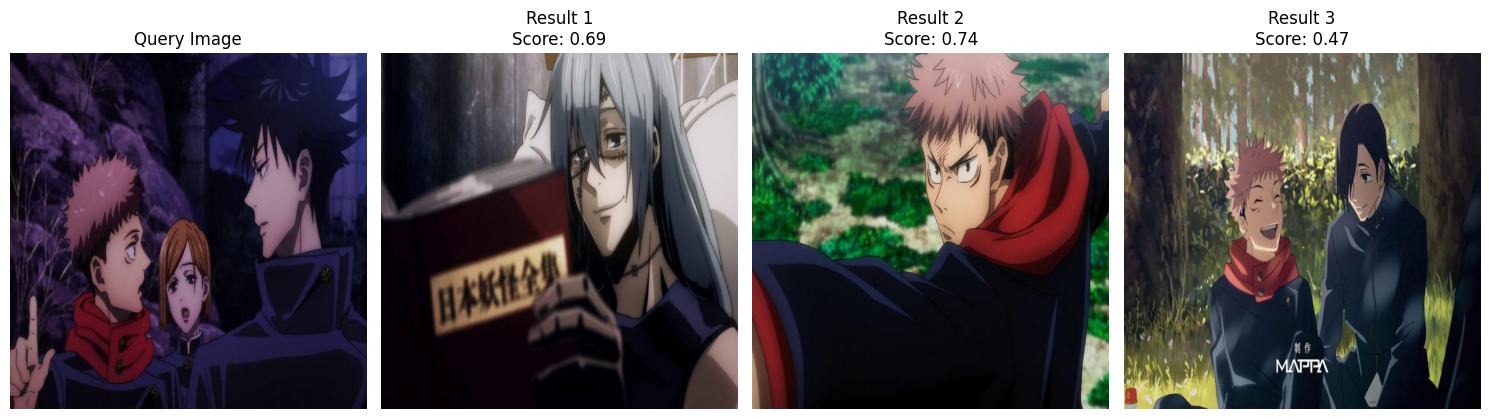

In [124]:
import matplotlib.pyplot as plt
from PIL import Image

def show_query_and_retrieved(query_path, retrieved_paths, scores=None):
    """
    Displays a query image alongside retrieved images.
    
    Parameters:
    - query_path: str, path to the query image.
    - retrieved_paths: list of str, paths to the retrieved images.
    - scores: list of float (optional), similarity scores for the retrieved images.
    """
    query_image = Image.open(query_path).convert('RGB')

    num_results = len(retrieved_paths)
    fig, axes = plt.subplots(1, num_results + 1, figsize=(15, 5))
    
    # Display the query image
    axes[0].imshow(query_image)
    axes[0].set_title('Query Image')
    axes[0].axis('off')

    # Loop through the retrieved paths and display each image
    for idx, path in enumerate(retrieved_paths):
        try:
            # Load retrieved image
            image = Image.open(path).convert('RGB')
            axes[idx + 1].imshow(image)

            # Add titles, optionally including scores
            if scores:
                axes[idx + 1].set_title(f'Result {idx + 1}\nScore: {scores[idx]:.2f}')
            else:
                axes[idx + 1].set_title(f'Result {idx + 1}')
        except FileNotFoundError:
            # Handle missing files
            axes[idx + 1].set_title(f'Result {idx + 1}\nFile Not Found')
            axes[idx + 1].imshow(Image.new('RGB', (100, 100), color='gray'))
        axes[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
query_path = 'deep learning/train/87d82c24-67a7-43c8-b094-895491c742be.jpg'  
retrieved_paths = [
    'deep learning/train/3108c2c4-d147-411b-a4bf-1a63c73e5c2e.jpg',  
    'deep learning/train/84a1a2bb-0283-47b2-ba0b-30dba14389c2.jpg',
    'deep learning/train/9713fb5a-0521-4314-9e3d-18c637891943.jpg'
]
scores = [0.69216603, 0.74341285, 0.46667615]  

show_query_and_retrieved(query_path, retrieved_paths, scores)

In [32]:
import pandas as pd
anime_metadata = pd.read_csv('anime-dataset-2023.csv')  # Adjust the path if needed
print(anime_metadata.head())
print(anime_metadata.info())


   anime_id                             Name             English name  \
0         1                     Cowboy Bebop             Cowboy Bebop   
1         5  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2         6                           Trigun                   Trigun   
3         7               Witch Hunter Robin       Witch Hunter Robin   
4         8                   Bouken Ou Beet   Beet the Vandel Buster   

                         Other name Score  \
0                         カウボーイビバップ  8.75   
1                    カウボーイビバップ 天国の扉  8.38   
2                             トライガン  8.22   
3  Witch Hunter ROBIN (ウイッチハンターロビン)  7.25   
4                            冒険王ビィト  6.94   

                                 Genres  \
0         Action, Award Winning, Sci-Fi   
1                        Action, Sci-Fi   
2             Action, Adventure, Sci-Fi   
3  Action, Drama, Mystery, Supernatural   
4      Adventure, Fantasy, Supernatural   

                               

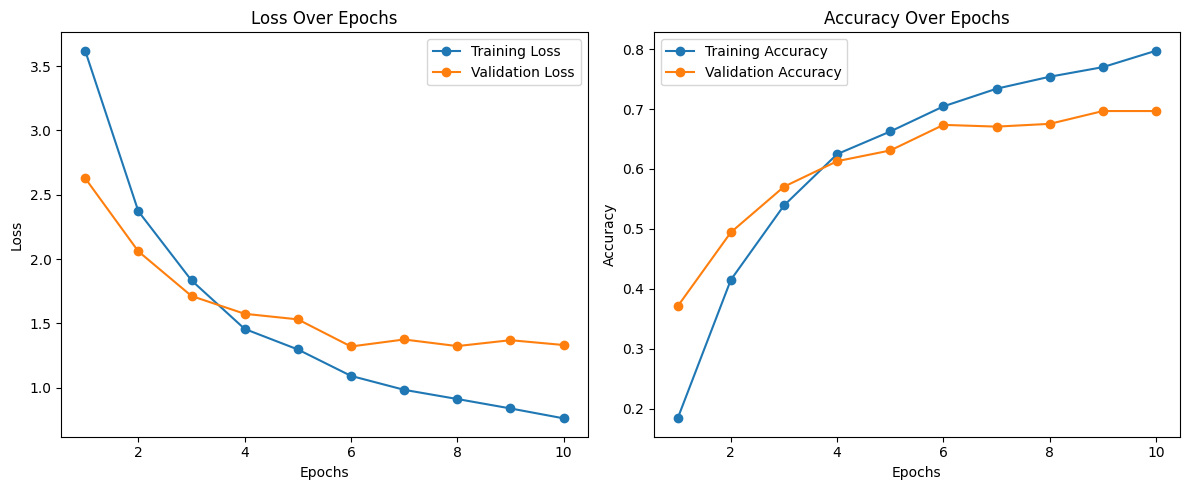

In [84]:
import matplotlib.pyplot as plt

# Updated metrics
train_loss = [3.6197, 2.3717, 1.8347, 1.4577, 1.2980, 1.0927, 0.9844, 0.9129, 0.8397, 0.7627]
val_loss = [2.6288, 2.0602, 1.7135, 1.5752, 1.5319, 1.3211, 1.3755, 1.3242, 1.3700, 1.3326]
train_acc = [0.1837, 0.4149, 0.5391, 0.6248, 0.6626, 0.7045, 0.7340, 0.7540, 0.7700, 0.7974]
val_acc = [0.3708, 0.4942, 0.5704, 0.6130, 0.6309, 0.6736, 0.6707, 0.6753, 0.6967, 0.6967]

# Plotting the metrics
def plot_training_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the updated metrics
plot_training_metrics(train_loss, val_loss, train_acc, val_acc)